In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn
# import pickleshare as ps

In [5]:
%run import_data

Continuing with existing version of data folder
Goodreads dataset loaded successfully as books_goodreads
Pandas dataframes (books_goodreads, books_big, book, users, ratings) loaded successfully
Columns in DataFrames 'users' and 'ratings' renamed
You can use the DataFrames 'books' or 'books_big' - they are exactly the same (big) dataset
Ready to go!


In [6]:
books_big.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l,genre
0,590085417,Heidi,Johanna Spyri,2021,Scholastic,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...,"Johanna Spyri, Shirley Temple, Movie tie-in, C..."
1,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,http://images.amazon.com/images/P/068160204X.0...,http://images.amazon.com/images/P/068160204X.0...,http://images.amazon.com/images/P/068160204X.0...,NaN
2,068107468X,Edgar Allen Poe Collected Poems,Edgar Allan Poe,2020,Bausch & Lombard,http://images.amazon.com/images/P/068107468X.0...,http://images.amazon.com/images/P/068107468X.0...,http://images.amazon.com/images/P/068107468X.0...,American Fantasy poetry
3,307124533,Owl's Amazing but True No. 2,Owl Magazine,2012,Golden Books,http://images.amazon.com/images/P/0307124533.0...,http://images.amazon.com/images/P/0307124533.0...,http://images.amazon.com/images/P/0307124533.0...,NaN
4,380816792,A Rose in Winter,Kathleen E. Woodiwiss,2011,Harper Mass Market Paperbacks,http://images.amazon.com/images/P/0380816792.0...,http://images.amazon.com/images/P/0380816792.0...,http://images.amazon.com/images/P/0380816792.0...,"Fiction, Historical Fiction, Romance, Fiction,..."


In [7]:
# dropping URLS columns as they are not needed

books_big.drop(['image_url_s', 'image_url_m', 'image_url_l'], axis=1, inplace=True)
books_big.head()

,isbn,book_title,book_author,year_of_publication,publisher,genre
0,590085417,Heidi,Johanna Spyri,2021,Scholastic,"Johanna Spyri, Shirley Temple, Movie tie-in, C..."
1,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,NaN
2,068107468X,Edgar Allen Poe Collected Poems,Edgar Allan Poe,2020,Bausch & Lombard,American Fantasy poetry
3,307124533,Owl's Amazing but True No. 2,Owl Magazine,2012,Golden Books,NaN
4,380816792,A Rose in Winter,Kathleen E. Woodiwiss,2011,Harper Mass Market Paperbacks,"Fiction, Historical Fiction, Romance, Fiction,..."


In [8]:
books_big.book_title.nunique()

202709

In [9]:
books_big.shape

(226493, 6)

In [10]:
ratings.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [11]:
# merge books with ratings df
books_ratings = pd.merge(books_big, ratings, on='isbn', how='left')
books_ratings.head()

,isbn,book_title,book_author,year_of_publication,publisher,genre,user_id,book_rating
0,590085417,Heidi,Johanna Spyri,2021,Scholastic,"Johanna Spyri, Shirley Temple, Movie tie-in, C...",NaN,NaN
1,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,NaN,16634.0,0.0
2,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,NaN,87141.0,0.0
3,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,NaN,169736.0,7.0
4,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,NaN,208406.0,0.0


In [21]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183600 entries, 1 to 350153
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 183600 non-null  object
 1   book_title           183600 non-null  object
 2   book_author          183537 non-null  object
 3   year_of_publication  183600 non-null  int64 
 4   publisher            183600 non-null  object
 5   genre                152371 non-null  object
 6   user_id              183600 non-null  int64 
 7   book_rating          183600 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 12.6+ MB


In [12]:
books_ratings.shape

(350155, 8)

In [13]:
books_ratings.isna().sum()

isbn                        0
book_title                  0
book_author               209
year_of_publication         0
publisher                   0
genre                   45437
user_id                166555
book_rating            166555
dtype: int64

In [14]:
books_ratings.dropna(subset=['user_id'], inplace=True)          # drop rows with no user_id
books_ratings.head()

,isbn,book_title,book_author,year_of_publication,publisher,genre,user_id,book_rating
1,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,NaN,16634.0,0.0
2,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,NaN,87141.0,0.0
3,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,NaN,169736.0,7.0
4,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,NaN,208406.0,0.0
5,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,NaN,230496.0,0.0


In [15]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183600 entries, 1 to 350153
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 183600 non-null  object 
 1   book_title           183600 non-null  object 
 2   book_author          183537 non-null  object 
 3   year_of_publication  183600 non-null  int64  
 4   publisher            183600 non-null  object 
 5   genre                152371 non-null  object 
 6   user_id              183600 non-null  float64
 7   book_rating          183600 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 12.6+ MB


In [16]:
books_ratings['user_id'] = books_ratings['user_id'].astype(int)
books_ratings['book_rating'] = books_ratings['book_rating'].astype(int)

In [17]:
books_ratings.to_csv('data/books_ratings.csv', index=False) # saving the merged dataframe to a csv file

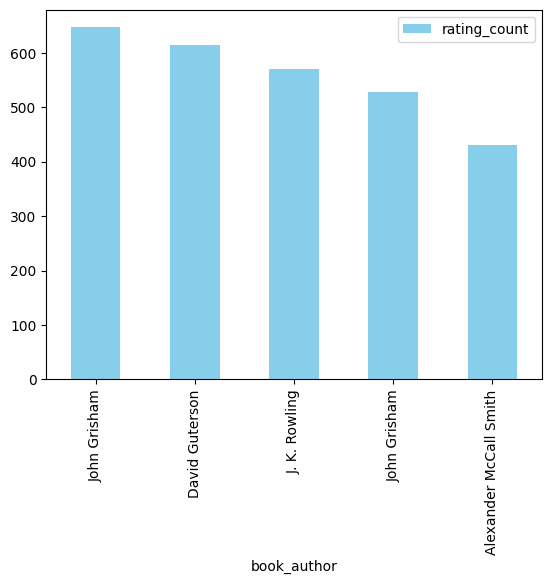

In [18]:
# Group by 'isbn' and count the number of ratings for each ISBN
isbn_rating_counts = books_ratings.groupby(['book_title', 'book_author', 'isbn']).size().reset_index(name='rating_count')

# Display the DataFrame to verify the result
ratings = isbn_rating_counts.sort_values('rating_count', ascending=False).head().plot(kind='bar', x='book_author', y='rating_count', color='skyblue')

In [19]:
isbn_rating_counts.head()

,book_title,book_author,isbn,rating_count
0,!%@ (A Nutshell handbook),Donnalyn Frey,1565920317,1
1,!%@ (A Nutshell handbook),Donnalyn Frey,1565920465,1
2,$30 Film School,Michael W. Dean,1592000673,1
3,$oft Money: The True Power in Our Nation's Cap...,E. L. Burton,1588204030,5
4,' Mein verwundetes Herz'. Das Leben der Lilli ...,Martin Doerry,342105634X,1


In [20]:
# including the average rating for each book
# Calculate the average rating for each book

to_be_rated = books_ratings[['isbn', 'book_rating']]
averageRating = to_be_rated.groupby('isbn')['book_rating'].mean().round(1).reset_index()
averageRating.rename(columns={'book_rating': 'average_rating'}, inplace=True)
average_rating = averageRating[['isbn','average_rating']]

# Merge the average ratings back with the original dataset
averageRatingdf = pd.merge(isbn_rating_counts, average_rating, on='isbn', how='left')

# Remove duplicate entries
#averageRatingdf = averageRatingdf[['isbn', 'average_rating']].drop_duplicates(subset=['isbn'])

averageRatingdf.head()  

,book_title,book_author,isbn,rating_count,average_rating
0,!%@ (A Nutshell handbook),Donnalyn Frey,1565920317,1,6.0
1,!%@ (A Nutshell handbook),Donnalyn Frey,1565920465,1,0.0
2,$30 Film School,Michael W. Dean,1592000673,1,8.0
3,$oft Money: The True Power in Our Nation's Cap...,E. L. Burton,1588204030,5,5.4
4,' Mein verwundetes Herz'. Das Leben der Lilli ...,Martin Doerry,342105634X,1,9.0


In [18]:
averageRatingdf.shape

(59913, 5)

### Creating a search engine ###

In [19]:
averageRatingdf["mod_titles"] = averageRatingdf['book_title'].str.replace("[^a-zA-Z0-9]", " ", regex=True)    #removing special characters from book titles   
averageRatingdf.head()

,book_title,book_author,isbn,rating_count,average_rating,mod_titles
0,!%@ (A Nutshell handbook),Donnalyn Frey,1565920317,1,6.0,A Nutshell handbook
1,!%@ (A Nutshell handbook),Donnalyn Frey,1565920465,1,0.0,A Nutshell handbook
2,$30 Film School,Michael W. Dean,1592000673,1,8.0,30 Film School
3,$oft Money: The True Power in Our Nation's Cap...,E. L. Burton,1588204030,5,5.4,oft Money The True Power in Our Nation s Cap...
4,' Mein verwundetes Herz'. Das Leben der Lilli ...,Martin Doerry,342105634X,1,9.0,Mein verwundetes Herz Das Leben der Lilli ...


In [20]:
#saving the average rating dataframe to a csv file'
averageRatingdf.to_csv('data/averageRatingdf.csv', index=False)

In [21]:
averageRatingdf.sort_values('rating_count', ascending=False).sample(15)

,book_title,book_author,isbn,rating_count,average_rating,mod_titles
32558,Mango and Mimosa,Suzanne St Albans,1860498949,3,6.3,Mango and Mimosa
58109,When the Buck Stops With You: Harry S. Truman ...,Alan Axelrod,1591840287,1,0.0,When the Buck Stops With You Harry S Truman ...
50930,The Odyssey - Teacher Guide,Anc Staff Novel Units,1561377600,1,0.0,The Odyssey Teacher Guide
49464,The Illustrated Lark Rise to Candleford: A Tri...,Flora Thompson,051755187X,2,8.0,The Illustrated Lark Rise to Candleford A Tri...
34780,"Muppet Manners: Or, the Night Gonzo Gave a Party",Pat Relf,039484713X,2,4.5,Muppet Manners Or the Night Gonzo Gave a Party
52592,The Sun Also Rises,Ernest Hemingway,684718081,1,0.0,The Sun Also Rises
25680,Jinx,Margaret Wild,1865082643,2,3.0,Jinx
59869,schwimmen gegen blond,Sandra Hoffmann,3406486983,1,1.0,schwimmen gegen blond
47914,The Death Prayer,David Bowker,1565048466,1,0.0,The Death Prayer
39394,"Profecia, La - Vol. 2 - La Espada de Joram",Tracy Hickman,8448030389,2,6.5,Profecia La Vol 2 La Espada de Joram


In [22]:
# Sort the DataFrame by 'average_rating' and 'rating_count' in descending order
sorted_df = averageRatingdf.sort_values(by=['average_rating', 'rating_count'], ascending=[False, False]).head(10)

# Display the top rows
sorted_df

,book_title,book_author,isbn,rating_count,average_rating,mod_titles
5134,Betsy and Joe (Betsy & Tacy),Maud Hart Lovelace,006440546X,4,10.0,Betsy and Joe Betsy Tacy
6465,"Bug, Witch and the Robot",Pete Abrams,1929462379,3,10.0,Bug Witch and the Robot
9660,Culpeper's Complete Herbal: A Book of Natural ...,Nicholas Culpeper,1853263451,3,10.0,Culpeper s Complete Herbal A Book of Natural ...
24717,Inside Avatar The Book: Achieving Enlightenment,Harry Palmer,1891575139,3,10.0,Inside Avatar The Book Achieving Enlightenment
27290,LA Metamorfosis (Colecci?on Literaria Lyc (Lee...,Franz Kafka,9505811322,3,10.0,LA Metamorfosis Colecci on Literaria Lyc Lee...
32430,"Mama, Do You Love Me?",Barbara M. Joosse,087701759X,3,10.0,Mama Do You Love Me
35508,Nausicaa of the Valley of Wind (Nausicaa of th...,Hayao Miyazaki,092927959X,3,10.0,Nausicaa of the Valley of Wind Nausicaa of th...
36700,Offerings at the Wall: Artifacts from the Viet...,Thomas B. Allen,1570360677,3,10.0,Offerings at the Wall Artifacts from the Viet...
39057,Power vs. Force: The Hidden Determinants of Hu...,David R. Hawkins,1561709336,3,10.0,Power vs Force The Hidden Determinants of Hu...
39731,Quantum Psychology: How Brain Software Program...,Robert Anton Wilson,1561840718,3,10.0,Quantum Psychology How Brain Software Program...


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Betsy and Joe  Betsy   Tacy '),
  Text(1, 0, 'Bug  Witch and the Robot'),
  Text(2, 0, 'Culpeper s Complete Herbal  A Book of Natural Remedies of Ancient Ills  The Wordsworth Collection Reference Library '),
  Text(3, 0, 'Inside Avatar The Book  Achieving Enlightenment'),
  Text(4, 0, 'LA Metamorfosis  Colecci on Literaria Lyc  Leer y Crear  '),
  Text(5, 0, 'Mama  Do You Love Me '),
  Text(6, 0, 'Nausicaa of the Valley of Wind  Nausicaa of the Valley of Wind  Graphic Novel '),
  Text(7, 0, 'Offerings at the Wall  Artifacts from the Vietnam Veterans Memorial Collection'),
  Text(8, 0, 'Power vs  Force  The Hidden Determinants of Human Behavior'),
  Text(9, 0, 'Quantum Psychology  How Brain Software Programs You and Your World')])

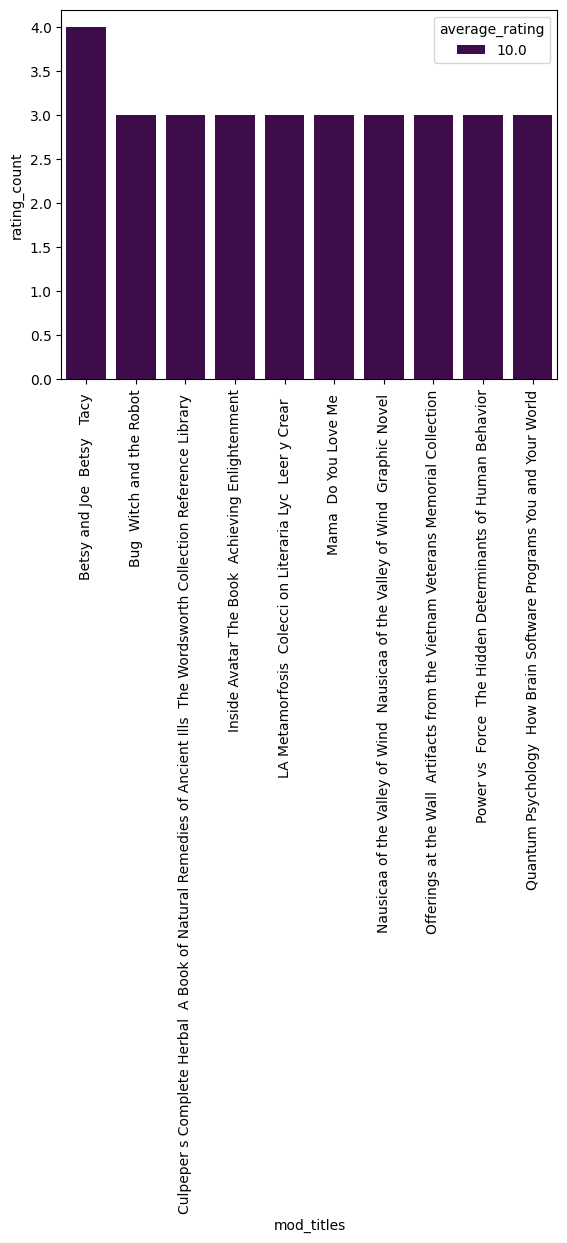

In [23]:
# Plot the top rated books  with the highest rating count   

sns.barplot(x='mod_titles', y='rating_count', hue='average_rating', data=sorted_df, palette='viridis')
plt.xticks(rotation=90)

In [24]:
averageRatingdf['mod_titles'] = averageRatingdf['mod_titles'].str.lower()    #converting book titles to lowercase

In [25]:
averageRatingdf['mod_titles'] = averageRatingdf['mod_titles'].str.replace('\s+', ' ', regex=True)    #removing extra spaces from book titles

In [26]:
averageRatingdf = averageRatingdf[averageRatingdf['mod_titles'].str.len() > 0]    #removing rows with empty book titles

In [28]:
#books_ratings.drop('user_id', axis=1, inplace=True)   #dropping user_id column

In [27]:
averageRatingdf.duplicated().sum()

0

In [28]:
averageRatingdf.rating_count.describe()

count    59913.000000
mean         3.063392
std          9.876267
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        647.000000
Name: rating_count, dtype: float64

<Axes: ylabel='rating_count'>

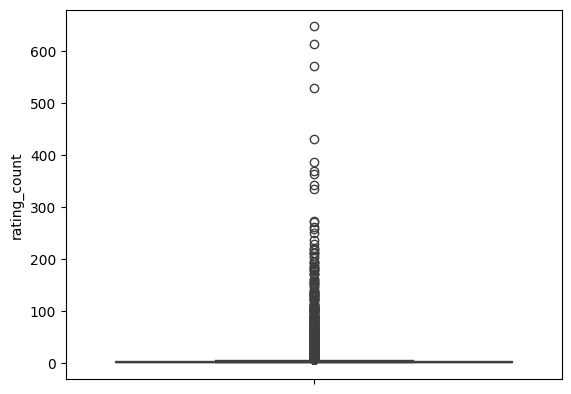

In [29]:
sns.boxplot(averageRatingdf.rating_count)

In [30]:
averageRatingdf['mod_titles'].nunique()

57253

#### Reducing shape of the dataframe ####

In [31]:
ratings = averageRatingdf[averageRatingdf['rating_count'] >= 15]    #filtering out books with less than 15 ratings
ratings.shape

(1487, 6)

#### Building a Term Frequency and then a Inverse Document Frequency matrix ####


In [32]:
# turning titles into TD-IDF matrix => Term Frequency-Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer takes a list of strings as input and turns it into a fd-idf matrix
vectorizer = TfidfVectorizer()

tdidf = vectorizer.fit_transform(ratings['mod_titles'])

In [33]:
# to do comparison between books, we need to calculate the cosine similarity between the books

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re


# query function:

def search(query, vectorizer):
# setting up a search query

    #query = 'The Hobbit'
# preparing the string in the same way as the mod titles above
    processed = re.sub('[^a-zA-Z0-9]', ' ', query.lower())

# we need to turn the query into a vector using the vectorizer

    query_vector = vectorizer.transform([processed])

# to find the similarities we calculate the cosine similarity between the query vector and the tdidf matrix
    similarity = cosine_similarity(query_vector, tdidf).flatten() # flatten is used to turn the matrix into a 1D array

# to find the indices of the 10 largest similarities

    indices = np.argpartition(similarity, -10)[-10:]

# use indices to index the titles

    results = ratings.iloc[indices]   

# as there are many books with the title "The Hobbit", we only want those with the highest number of ratings

    results = results.sort_values(by='rating_count', ascending=False)

    return results.head(10)


In [34]:
search('the hitchhikers guide to the galaxy', vectorizer)

,book_title,book_author,isbn,rating_count,average_rating,mod_titles
48858,The Girls' Guide to Hunting and Fishing,Melissa Bank,067088300X,157,3.3,the girls guide to hunting and fishing
48677,The Four Agreements: A Practical Guide to Pers...,Don Miguel Ruiz,1878424319,133,3.5,the four agreements a practical guide to perso...
47831,The Dance of Anger: A Woman's Guide to Changin...,Harriet Lerner,006091565X,52,2.3,the dance of anger a woman s guide to changing...
51362,The Power of Now: A Guide to Spiritual Enlight...,Eckhart Tolle,1577311523,24,3.5,the power of now a guide to spiritual enlighte...
50426,The Mastery of Love: A Practical Guide to the ...,Miguel Ruiz,1878424424,21,3.9,the mastery of love a practical guide to the a...
51980,The Salmon of Doubt: Hitchhiking the Galaxy On...,DOUGLAS ADAMS,1400045088,21,3.6,the salmon of doubt hitchhiking the galaxy one...
36739,"Oh, the Things I Know! A Guide to Success, or,...",Al Franken,052594673X,19,3.0,oh the things i know a guide to success or fai...
54502,To the Lighthouse,Virginia Woolf,1853260916,17,1.9,to the lighthouse
31028,Living the Simple Life: A Guide to Scaling Dow...,Elaine St. James,078686219X,17,3.4,living the simple life a guide to scaling down...
4568,Bart Simpson's Guide to Life: A Wee Handbook f...,Matt Groening,006096975X,15,4.3,bart simpson s guide to life a wee handbook fo...


In [35]:
# creating my list of liked books
liked_books = ['006440546X', '1929462379', '1853263451', '1891575139', '9505811322', '1561840718']
liked_books

['006440546X',
 '1929462379',
 '1853263451',
 '1891575139',
 '9505811322',
 '1561840718']

### Making recommendations based on my liked books ###

#### step 1: find all the users that liked the same books as us ####

In [36]:
ratings.head()

,book_title,book_author,isbn,rating_count,average_rating,mod_titles
161,16 Lighthouse Road,Debbie Macomber,1551668300,65,1.9,16 lighthouse road
177,1984,George Orwell,207036822X,15,4.5,1984
200,"20,000 Leagues Under the Sea (Wordsworth Colle...",Jules Verne,1853260312,24,2.3,20 000 leagues under the sea wordsworth collec...
230,204 Rosewood Lane,Debbie Macomber,1551669293,71,1.7,204 rosewood lane
272,311 Pelican Court,Debbie Macomber,1551667193,46,2.9,311 pelican court


In [37]:
# use original dataset to find users who liked the same books as me (including individual ratings)

#books_ratings.head()

books_ratings_short = books_ratings[['user_id', 'isbn', 'book_rating', 'book_title']]   

books_ratings_short.head()

filtered_ratings = books_ratings_short[books_ratings_short['isbn'].isin(liked_books) & (books_ratings_short['book_rating'] > 8)]  #filtering out books with ratings higher or equal  8   

print(filtered_ratings.shape)

# create a set with users who liked the same books as me

overlap_users = set()

# # Create tuples (user_id, isbn, book_rating) for the filtered rows
overlap_users = set(filtered_ratings.apply(lambda row: (row['user_id'], row['isbn'],row['book_title'], row['book_rating']), axis=1))

# # Display the overlap_users set
overlap_users

(19, 4)


{(30735, '006440546X', 'Betsy and Joe (Betsy & Tacy)', 10),
 (56399,
  '1853263451',
  "Culpeper's Complete Herbal: A Book of Natural Remedies of Ancient Ills (The Wordsworth Collection Reference Library)",
  10),
 (70464, '1891575139', 'Inside Avatar The Book: Achieving Enlightenment', 10),
 (75591, '006440546X', 'Betsy and Joe (Betsy & Tacy)', 10),
 (76626,
  '1853263451',
  "Culpeper's Complete Herbal: A Book of Natural Remedies of Ancient Ills (The Wordsworth Collection Reference Library)",
  10),
 (83152, '1891575139', 'Inside Avatar The Book: Achieving Enlightenment', 10),
 (93426, '1929462379', 'Bug, Witch and the Robot', 10),
 (95359, '006440546X', 'Betsy and Joe (Betsy & Tacy)', 10),
 (97324,
  '9505811322',
  'LA Metamorfosis (Colecci?on Literaria Lyc (Leer y Crear))',
  10),
 (141310,
  '1561840718',
  'Quantum Psychology: How Brain Software Programs You and Your World',
  10),
 (141322,
  '1561840718',
  'Quantum Psychology: How Brain Software Programs You and Your World',


In [38]:
# making set a dataframe containing any user who read the same book as us and rated the book higher than 8
overlap_users_df = pd.DataFrame(list(overlap_users), columns=['user_id', 'isbn', 'book_title', 'book_rating'])
overlap_users_df

,user_id,isbn,book_title,book_rating
0,248915,1929462379,"Bug, Witch and the Robot",10
1,187810,9505811322,LA Metamorfosis (Colecci?on Literaria Lyc (Lee...,10
2,231977,1891575139,Inside Avatar The Book: Achieving Enlightenment,10
3,93426,1929462379,"Bug, Witch and the Robot",10
4,95359,006440546X,Betsy and Joe (Betsy & Tacy),10
5,83152,1891575139,Inside Avatar The Book: Achieving Enlightenment,10
6,254206,1929462379,"Bug, Witch and the Robot",10
7,75591,006440546X,Betsy and Joe (Betsy & Tacy),10
8,56399,1853263451,Culpeper's Complete Herbal: A Book of Natural ...,10
9,76626,1853263451,Culpeper's Complete Herbal: A Book of Natural ...,10


In [39]:
len(overlap_users_df)

19

In [40]:
overlap_users_df['isbn'] = overlap_users_df['isbn'].astype(str)   #converting isbn to string

#### step 2: finding what those users liked ####

In [41]:
# finding books that the users in the overlap_users_df have read and rated highly

#filtering out books read by users in the overlap_users_df
total_books = books_ratings_short[books_ratings_short['user_id'].isin(overlap_users_df['user_id'])]

#filtering out books with ratings higher than 8
total_books = total_books[total_books['book_rating'] > 8]

#filtering out books that I have already liked
recommended = total_books[~total_books['isbn'].isin(liked_books)]

#finding the top 10 books that the users in the overlap_users_df have read and rated highly
recommended_2 = recommended['isbn'].value_counts().head(10)

In [42]:
len(recommended_2)

10

In [43]:
total_books.head()

,user_id,isbn,book_rating,book_title
13,76626,1903436346,9,The Winter's Tale - Arden Shakespeare : Third ...
2441,56399,1561841625,10,The Earth Will Shake (Historical Illuminatus C...
5706,95359,193072229X,10,MoveOn's 50 Ways to Love Your Country: How to ...
5791,56399,1568821573,10,H. P. Lovecraft's Dreamlands (Call of Cthulhu ...
6664,156150,1400052971,9,"The Last Good Time : Skinny D'Amato, the Notor..."


In [44]:
total_books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 385 entries, 13 to 349713
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      385 non-null    int64 
 1   isbn         385 non-null    object
 2   book_rating  385 non-null    int64 
 3   book_title   385 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.0+ KB


In [45]:
# Convert recommended_2 Series to DataFrame
recommended_2_df = recommended_2.reset_index()
recommended_2_df.columns = ['isbn', 'count']



In [46]:
recommended_2_df

,isbn,count
0,1929462093,3
1,192946200X,3
2,1929462239,3
3,1561840033,3
4,1561840564,3
5,044021985X,2
6,043935806X,2
7,042510429X,2
8,055357289X,2
9,031242227X,2


In [47]:
# Merge with books DataFrame to get book titles
recommended_with_titles = pd.merge(recommended_2_df, total_books[['isbn', 'book_title']], on='isbn', how='left')

# Display the result
recommended_with_titles[['isbn', 'book_title']].value_counts().reset_index(name='count')

,isbn,book_title,count
0,1561840033,Cosmic Trigger I : Final Secret of the Illuminati,3
1,1561840564,Prometheus Rising,3
2,192946200X,Sluggy Freelance: When Holidays Attack! (Book 3),3
3,1929462093,Sluggy Freelance: Game Called on Account of Na...,3
4,1929462239,"Sluggy Freelance: Yippy Skippy, the Evil! (Boo...",3
5,031242227X,Running with Scissors: A Memoir,2
6,042510429X,The Third Deadly Sin,2
7,043935806X,Harry Potter and the Order of the Phoenix (Boo...,2
8,044021985X,"Tomorrow, When The War Began",2
9,055357289X,"Shadow Dawn (Chronicles of the Shadow War, Boo...",2


#### step 3: fine tuning the recommendations ####

In [48]:
total_books.head()

,user_id,isbn,book_rating,book_title
13,76626,1903436346,9,The Winter's Tale - Arden Shakespeare : Third ...
2441,56399,1561841625,10,The Earth Will Shake (Historical Illuminatus C...
5706,95359,193072229X,10,MoveOn's 50 Ways to Love Your Country: How to ...
5791,56399,1568821573,10,H. P. Lovecraft's Dreamlands (Call of Cthulhu ...
6664,156150,1400052971,9,"The Last Good Time : Skinny D'Amato, the Notor..."


In [49]:
#creating a column book_count  
recommended = recommended.copy() # this to handle the warning from pandas
recommended.loc[:, 'book_count'] = recommended.groupby('isbn')['isbn'].transform('count')
recommended.head()

,user_id,isbn,book_rating,book_title,book_count
13,76626,1903436346,9,The Winter's Tale - Arden Shakespeare : Third ...,1
2441,56399,1561841625,10,The Earth Will Shake (Historical Illuminatus C...,1
5706,95359,193072229X,10,MoveOn's 50 Ways to Love Your Country: How to ...,1
5791,56399,1568821573,10,H. P. Lovecraft's Dreamlands (Call of Cthulhu ...,1
6664,156150,1400052971,9,"The Last Good Time : Skinny D'Amato, the Notor...",1


In [50]:
recommended.book_count.unique()

array([1, 2, 3])

In [51]:
recommended.head()

,user_id,isbn,book_rating,book_title,book_count
13,76626,1903436346,9,The Winter's Tale - Arden Shakespeare : Third ...,1
2441,56399,1561841625,10,The Earth Will Shake (Historical Illuminatus C...,1
5706,95359,193072229X,10,MoveOn's 50 Ways to Love Your Country: How to ...,1
5791,56399,1568821573,10,H. P. Lovecraft's Dreamlands (Call of Cthulhu ...,1
6664,156150,1400052971,9,"The Last Good Time : Skinny D'Amato, the Notor...",1


In [52]:
# creatig a popularity score for each book / we want to look for books that are popular among users like us
recommended = recommended.copy() # this to handle the pandas warning
recommended.loc[:, 'popularity'] = recommended['book_count'] * recommended['book_count'] / recommended['book_rating']
recommended.head()

,user_id,isbn,book_rating,book_title,book_count,popularity
13,76626,1903436346,9,The Winter's Tale - Arden Shakespeare : Third ...,1,0.111111
2441,56399,1561841625,10,The Earth Will Shake (Historical Illuminatus C...,1,0.100000
5706,95359,193072229X,10,MoveOn's 50 Ways to Love Your Country: How to ...,1,0.100000
5791,56399,1568821573,10,H. P. Lovecraft's Dreamlands (Call of Cthulhu ...,1,0.100000
6664,156150,1400052971,9,"The Last Good Time : Skinny D'Amato, the Notor...",1,0.111111


In [53]:
tailored_recs = recommended.sort_values('popularity', ascending=False)
tailored_recs.head()

,user_id,isbn,book_rating,book_title,book_count,popularity
117249,93426,192946200X,9,Sluggy Freelance: When Holidays Attack! (Book 3),3,1.0
100504,93426,1929462093,9,Sluggy Freelance: Game Called on Account of Na...,3,1.0
246343,141322,1561840564,10,Prometheus Rising,3,0.9
75050,248915,1929462239,10,"Sluggy Freelance: Yippy Skippy, the Evil! (Boo...",3,0.9
100506,254206,1929462093,10,Sluggy Freelance: Game Called on Account of Na...,3,0.9


In [54]:
tailored_recs[['isbn', 'book_title', 'popularity']].value_counts().reset_index(name='count').head(10)

,isbn,book_title,popularity,count
0,1561840033,Cosmic Trigger I : Final Secret of the Illuminati,0.900000,3
1,1561840564,Prometheus Rising,0.900000,3
2,1929462239,"Sluggy Freelance: Yippy Skippy, the Evil! (Boo...",0.900000,3
3,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,0.400000,2
4,042510429X,The Third Deadly Sin,0.400000,2
5,043935806X,Harry Potter and the Order of the Phoenix (Boo...,0.400000,2
6,044021985X,"Tomorrow, When The War Began",0.444444,2
7,031242227X,Running with Scissors: A Memoir,0.444444,2
8,192946200X,Sluggy Freelance: When Holidays Attack! (Book 3),0.900000,2
9,1929462093,Sluggy Freelance: Game Called on Account of Na...,0.900000,2
